In [2]:
%matplotlib inline


# Classifier comparison


A comparison of a several classifiers in scikit-learn.



In [23]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
#from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

Automatically created module for IPython interactive environment


### Loading and pre-processing data

To begin with, I replaced NA's with zeros. 

Later, I will see how many features were mostly "NA". If they are not important, I will probably drop them. 

I'm creating two arrays: one to store how many NAs were in each feature, and the other to store how many NAs were in each observation. 

In [24]:
trainX = [] 
NA_counts_per_feature = []
for i in range(0, 334): 
    NA_counts_per_feature.append(0)

NA_counts_per_observation = [] 
for i in range(0, 17379): 
    NA_counts_per_observation.append(0)

with open("/home/lu/Documents/School/81_machine_learning/HW3/HW3/trainingData.txt", 'r') as rp: 
    row_i = 0 
    for line in rp.read().split("\n"): 
        row = line.split("\t") 
        column_i = 0 # cell index 
        for cell in row: 
            try: 
                row[column_i] = float(cell)
            except ValueError: 
                row[column_i] = 0 
                NA_counts_per_feature[column_i]+=1 
                NA_counts_per_observation[row_i]+=1 
            column_i+=1  
        row_i +=1 
        trainX.append(row)
        
trainY = [] 
with open("/home/lu/Documents/School/81_machine_learning/HW3/HW3/trainingTruth.txt", 'r') as rp: 
    for line in rp.read().split("\n"): 
        trainY.append(line)

The max number of NAs in a column is 81, and 334 columns are missing data. The max number of NAs in a row is 7, and 11620 rows are missing data. 

This suggests that there aren't that many missing values per column. My worry that replacing them with zero might affect the model's predictive power. I could replace the missing values with the average of all of the columns. 

The max number of NAs in a column is 81, and 334 columns are missing data
The max number of NAs in a row is 7, and 11620 rows are missing data


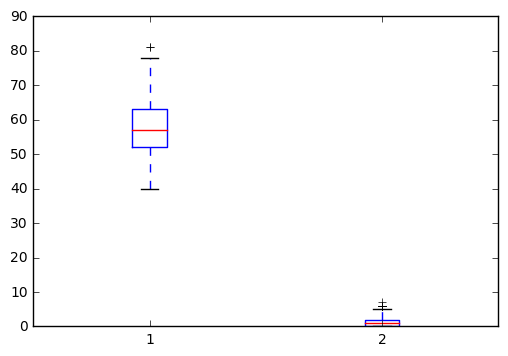

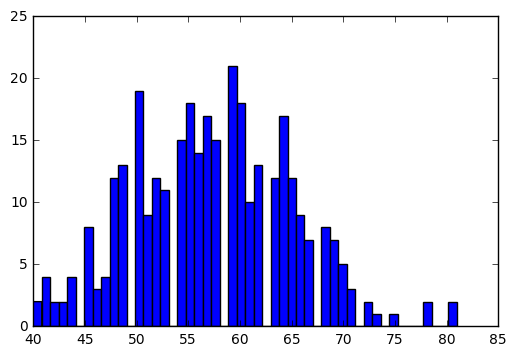

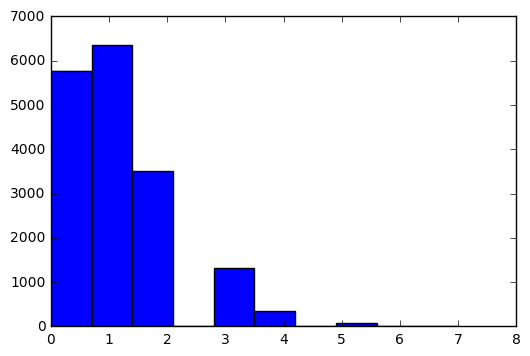

In [25]:
import numpy as np 
import matplotlib as mpl 
import matplotlib.pyplot as plt 

NA_per_feature = np.array(NA_counts_per_feature)
NA_per_observation = np.array(NA_counts_per_observation)

c = len([x for x in NA_counts_per_feature if x > 0 ])
r = len([x for x in NA_per_observation if x > 0 ])

print("The max number of NAs in a column is %d, and %d columns are missing data" % (max(NA_per_feature), c))
print("The max number of NAs in a row is %d, and %d rows are missing data" % (max(NA_per_observation), r)) 

data_to_plot = [NA_per_feature, NA_per_observation]

plt.boxplot(data_to_plot)
plt.show() 

n, bins, patches = plt.hist(NA_per_feature, 50)
plt.show() 
n, bins, patches = plt.hist(NA_per_observation, 10)
plt.show() 

In order to replace missing values with the average of the feature, first calculate the averages of all the columns. 

The averages of all the features are quite small. 

Then, reload all the data, replacing NAs with the averages. 

In [27]:
### Split data into training and tests sets 
arrayX = np.array(trainX[0:100])
arrayY = np.array(trainY[0:100])

feature_means = np.mean(arrayX, axis=0)

with open("/home/lu/Documents/School/81_machine_learning/HW3/HW3/trainingData.txt", 'r') as rp: 
    for line in rp.read().split("\n"): 
        row = line.split("\t") 
        column_i = 0 # cell index 
        for cell in row: 
            try: 
                row[column_i] = float(cell)
            except ValueError: 
                row[column_i] = feature_means[column_i]
            column_i+=1  
        trainX.append(row)
        
trainY = [] 
with open("/home/lu/Documents/School/81_machine_learning/HW3/HW3/trainingTruth.txt", 'r') as rp: 
    for line in rp.read().split("\n"): 
        trainY.append(line)



### Feature selection - dropping mostly empty columns or rows 

For this data, we have filled NA's with zeros. Perhaps that is not good for some columns that contain legitimate small numbers. Dropping features that are mostly populated with NAs might improve things. 

Similarly, we can drop rows of data that contain too many NA's to be useful. From running this model on subsets of the data, a training set of 6K of the data creates a model that is nearly as good as a model that used 10K of the data (splitting the entire dataset). Therefore, we might be able to drop observations without reducing our dataset to a point where the model accuracy suffered. 

In [30]:
arrayX = np.array(trainX[0:17377])
arrayY = np.array(trainY[0:17377])

X_train, X_test, y_train, y_test = train_test_split(arrayX, arrayY, test_size=0.4, random_state=0)

print(len(arrayX))

17377


In [29]:
classifiers = {
    "Nearest Neighbors": KNeighborsClassifier(3),
    "Linear SVC": SVC(kernel="linear", C=0.5),
    "RBF SVM": SVC(gamma=2, C=1),
    "DecisionTree_old": DecisionTreeClassifier(max_depth=5), 
    "RandomForest_old": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "DecisionTree": DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=20, random_state=0),
    "Rand Forest": RandomForestClassifier(n_estimators=30, criterion='entropy', max_depth=20, min_samples_leaf=20, 
                           bootstrap=True, oob_score=False, random_state=0 ),
    "Adaboost": AdaBoostClassifier(),
    "GaussianNB": GaussianNB(),
    "Logit": LogisticRegression(C=1), 
    "Logit l=2": LogisticRegression(C=0.5), 
    "Logit l=4": LogisticRegression(C=0.25),
    "QDA": QuadraticDiscriminantAnalysis()
}
print("Classifier | Score on Test | Score on Train ")
print("--- | --- | --- | ")


for name, classifier in  classifiers.items() : 
    clf=classifier
    clf.fit(X_train, y_train)
    row = [
            clf.score(X_test, y_test) ,clf.score(X_train, y_train), #comparing test and training on 4/6 split
         ]
    print(name + "|" + "|".join(["%.3f" % x for x in row]) )

Classifier | Score on Test | Score on Train 
--- | --- | --- | 
Rand Forest|0.613|0.772
QDA|0.665|1.000
DecisionTree_old|0.462|0.503
RandomForest_old|0.476|0.502
Logit l=2|0.761|0.793
DecisionTree|0.471|0.517


KeyboardInterrupt: 

Classifier | test score NA=0 | training NA=0 |  test score NA=mean | training NA=mean | change in accuracy | change in ranking | 
--- | --- | --- | --- | --- | --- | 
GaussianNB|0.756|0.799 |0.771|0.796 | 0.015 | 0 
Logit|0.739|0.800 |0.764 | 0.793 | 0.025 | 0 
Logit l=2|0.737|0.799 |0.761 |0.793 | 0.024 | 0 
Logit l=4|0.728|0.794 |0.758 |0.792 | 0.03 | 0 
Linear SVM|0.704|0.832|0.757|0.820| **0.053** | 0 
Adaboost|0.600|0.632 |0.621|0.650 | 0.021 | -1 
Rand Forest|0.593|0.787|0.613|0.772 | 0.02 | 0   
Nearest Neighbors|0.579 |0.606|0.750 |0.740| **0.171** | 0   
QDA|0.556|1.000|0.665|1.000| **0.109** | **+3**
DecisionTree_old|0.460|0.526|0.462|0.503| 0.002 | -1
DecisionTree|0.440|0.497|0.471|0.517| 0.031 | +1
RandomForest_old|0.389|0.436|0.461|0.494 | **0.072** | 0 
RBF SVM|0.343|1.000|0.329|1.000| -0.014 | 0 


In [22]:
testX = [] 
with open("/home/lu/Documents/School/81_machine_learning/HW3/HW3/testData.txt", 'r') as rp: 
    for line in rp.read().split("\n"): 
        row = line.split("\t") 
        i = 0 
        for cell in row: 
            try: 
                row[i] = float(cell)
            except ValueError: 
                row[i] = 0 
            i+=1 
        testX.append(row)

blindX = [] 
with open("/home/lu/Documents/School/81_machine_learning/HW3/HW3/blindData.txt", 'r') as rp: 
    for line in rp.read().split("\n"): 
        row = line.split("\t") 
        i = 0 
        for cell in row: 
            try: 
                row[i] = float(cell)
            except ValueError: 
                row[i] = 0 
            i+=1 
        blindX.append(row[0:334])
        
arrayTest = np.array(testX[0:8179])
arrayBlind = np.array(blindX[0:20049])

clf=GaussianNB()
clf.fit(arrayX, arrayY)


## Calculate AUC on model predictions and trainingTruth 
import operator 

prob_array = clf.predict_proba(arrayX)

with open('wang_ochoa_train_predictions.csv', 'w') as wp: 
    for row in prob_array: 
        index, value = max(enumerate(row), key=operator.itemgetter(1))
        line_list = ["%.3f" % x for x in row] + [str(index+1)] 
        line_str = '\t'.join(line_list)+'\n'
        wp.write(line_str)

prob_array = clf.predict_proba(arrayTest)

with open('wang_ochoa_test_predictions.csv', 'w') as wp: 
    for row in prob_array: 
        index, value = max(enumerate(row), key=operator.itemgetter(1))
        line_list = ["%.3f" % x for x in row] + [str(index+1)] 
        line_str = '\t'.join(line_list)+'\n'
        wp.write(line_str)

        
prob_array = clf.predict_proba(arrayBlind)

with open('wang_ochoa_blind_predictions.csv', 'w') as wp: 
    for row in prob_array: 
        index, value = max(enumerate(row), key=operator.itemgetter(1))
        line_list = ["%.3f" % x for x in row] + [str(index+1)] 
        line_str = '\t'.join(line_list)+'\n'
        wp.write(line_str)